# Installing and importing libraries

In [1]:
# for text manipulation
import nltk 
import string
import re

# for data manipulation
import pandas as pd
import numpy as np

import time

# for data vizualisation
import matplotlib.pyplot as plt
import seaborn as sns

# importing different libraries for analysis, processing and classification
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
from nltk.tag import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer

# performance evaluation criteria 
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

import pickle

## Importing the Dataset

In [2]:
tweets = pd.read_csv('sentiment_tweets3.csv')

In [3]:
tweets.head()

,Unnamed: 0,message,label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


## Data Cleaning

In [4]:
tweets.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10314 non-null  object
 1   label    10314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.3+ KB


In [6]:
train, test = train_test_split(tweets, test_size=0.3, stratify=tweets['label'], random_state=42)

In [7]:
def clean_message(message):
    
    # Removing usernames
    message = re.sub(r'\w*@\w*', '', message)

    # Removing URLs
    message = re.sub(r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', '', message, flags=re.MULTILINE)
    
    stop_words = stopwords.words('english')
    tokens = word_tokenize(message)
    
    cleaned_tokens = []
    
    for token, tag in pos_tag(tokens):
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
            
        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        
        if token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token)

    return cleaned_tokens

In [8]:
start_time = time.time()
tfidf_v = TfidfVectorizer(use_idf=True, analyzer = clean_message, min_df = 10, max_df = 0.80, ngram_range=(1,2))
tfidf_v.fit_transform(train['message'].values)
train_feature_set = tfidf_v.transform(train['message'].values)
test_feature_set = tfidf_v.transform(test['message'].values)
print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  0.95  mins


In [9]:
y_train = train['label'].values
y_test = test['label'].values 

In [10]:
start_time = time.time()
lr = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
lr.fit(train_feature_set, y_train)
y_pred = lr.predict(test_feature_set)
print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to train model and make predictions:  0.02  mins


In [11]:
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Accuracy:  0.982
F1:  0.957


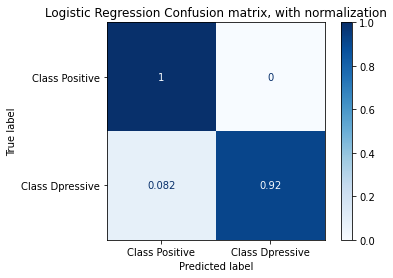

In [12]:
disp = metrics.plot_confusion_matrix(lr, test_feature_set, y_test,
                                 display_labels=['Class Positive', 'Class Dpressive'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

In [13]:
text_vec = tfidf_v.transform(["Lately I have been feeling unsure of myself as a person & an artist"])
lr.predict_proba(text_vec)

array([[0.90163414, 0.09836586]])

In [14]:
pickle.dump(tfidf_v, open('vectorizer.pickle', 'wb'))
pickle.dump(lr, open('classifier.pickle', "wb"))